In [ ]:
import loader
import torch
from tqdm import tqdm

model_dir = "../fine_tuned/tram_swipe/28_tram_FacebookAI-roberta-large"
model_name = "FacebookAI/roberta-large"
dataset_name = "tram"
device = "cuda:1"

model, tokenizer = loader.load_finetuned_model(model_dir)
_, _, data_loader = loader.load_datasets(
    dataset_name, 16, tokenizer, per_document=False
)

model.to(device)
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in tqdm(data_loader):

        input_ids = torch.as_tensor(batch["input_ids"]).to(device)
        attn_mask = torch.as_tensor(batch["attention_mask"]).to(device)
        labels = torch.as_tensor(batch["labels"]).to(device)
        all_labels.extend(labels.cpu().numpy())
        out = model(input_ids=input_ids, attention_mask=attn_mask)
        probs = out.logits.sigmoid()
        preds = torch.where(probs > 0.5, 1.0, 0.0)
        all_preds.extend(preds.cpu().numpy())

/home/tomasso/sok-bert-experiments/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 239/239 [02:50<00:00,  1.40it/s]


In [2]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = list(model.config.label2id.keys())

print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0.0))

              precision    recall  f1-score   support

   T1003.001       0.67      0.76      0.71        29
       T1005       0.67      0.11      0.19        18
       T1012       0.00      0.00      0.00         5
       T1016       0.00      0.00      0.00         9
   T1021.001       0.79      0.74      0.77        31
       T1027       0.65      0.55      0.59       121
       T1033       0.00      0.00      0.00        11
   T1036.005       0.71      0.45      0.56        11
       T1041       0.75      0.40      0.52        15
       T1047       0.67      0.40      0.50        10
   T1053.005       0.86      0.75      0.80        24
       T1055       0.88      0.56      0.69        41
   T1056.001       0.93      0.93      0.93        14
       T1057       1.00      0.27      0.43        11
   T1059.003       0.73      0.71      0.72        65
       T1068       0.00      0.00      0.00         1
   T1070.004       0.62      0.50      0.55        26
   T1071.001       0.50    

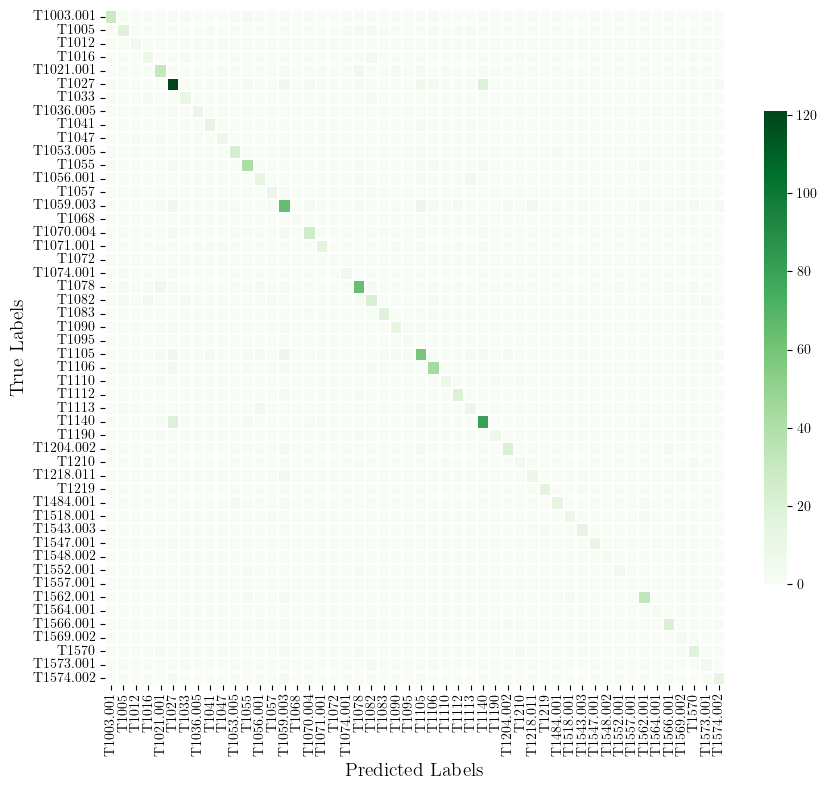

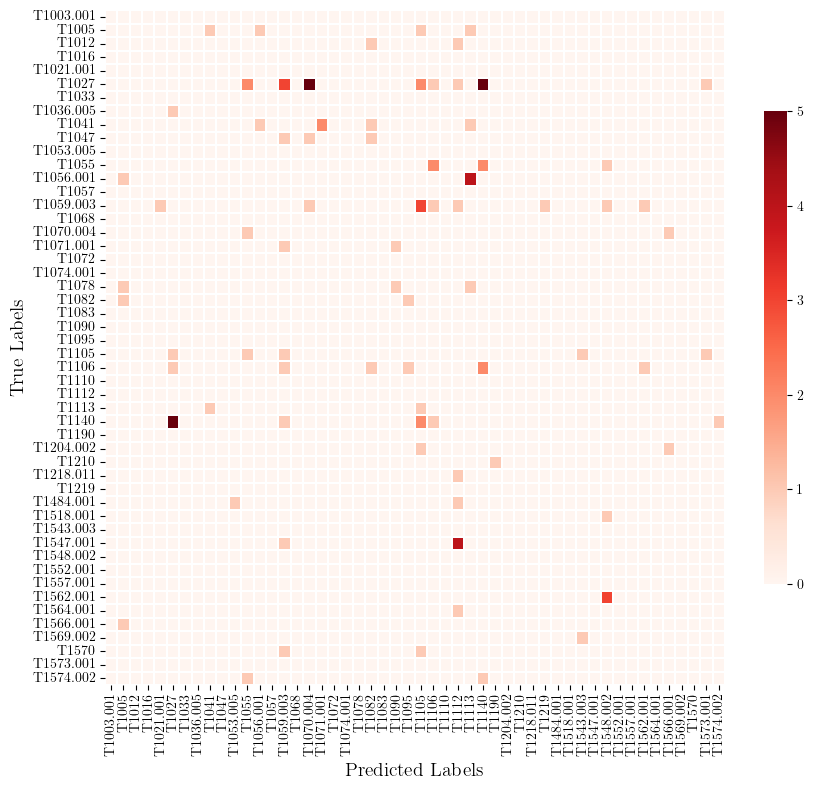

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

Y_true = np.array(all_labels)
Y_pred = np.array(all_preds)

# Number of labels
num_labels = Y_true.shape[1]

# Initialize valid and error co-occurrence matrices
valid_co_occurrence = np.zeros((num_labels, num_labels), dtype=int)
error_co_occurrence = np.zeros((num_labels, num_labels), dtype=int)

# Populate the matrices
for true_labels, pred_labels in zip(Y_true, Y_pred):
    for i in range(num_labels):
        for j in range(num_labels):
            if true_labels[i] == 1 and true_labels[j] == 1:
                # Valid co-occurrence (both true)
                valid_co_occurrence[i, j] += 1
            elif true_labels[i] == 1 and pred_labels[j] == 1 and true_labels[j] == 0:
                # Error co-occurrence (i is true, j is an incorrect prediction)
                error_co_occurrence[i, j] += 1

# Define a function to plot heatmaps
def plot_heatmap(matrix, title, cmap, xticks=None, yticks=None):
    plt.figure(figsize=(10, 9))  # Larger figure for readability
    ax = sns.heatmap(matrix, annot=False, cmap=cmap, fmt=".2f", linewidths=0.01, linecolor='white', cbar_kws={'shrink': 0.7})
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)

    # Set xticks and yticks inside the grid
    ax.set_xticks(np.arange(len(xticks)) + 0.5)
    ax.set_yticks(np.arange(len(yticks)) + 0.5)
    ax.set_xticklabels(xticks, rotation=90, ha='center',)
    ax.set_yticklabels(yticks, rotation=0, va='center')
    # ax.tick_params(axis='x', bottom=False, top=False, labelbottom=False, labeltop=True)
    # ax.tick_params(axis='y', left=False, right=False)
    # Move ticks inside the heatmap
    # plt.grid(visible=True, which='major', color='gray', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig("../plots/heatmap.pdf", bbox_inches='tight')
    plt.show()

# Label names for readability
labels = target_names

# Plot valid co-occurrence matrix
plot_heatmap(valid_co_occurrence, "Valid Label Co-Occurrence Matrix", cmap="Greens", xticks=labels, yticks=labels)

# Plot error co-occurrence matrix
plot_heatmap(error_co_occurrence, "Error Label Co-Occurrence Matrix", cmap="Reds", xticks=labels, yticks=labels)
